####  Transfer Learning

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58782000 @  0x7f51b7aa92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using PyTorch version:', torch.__version__, 'Device:', device)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using PyTorch version: 0.4.1 Device: cuda


In [0]:
def train(model, trainLoader, criterion, optimizer, epoch, logInterval=100):
    model.train()
    for batchIdx, (data, target) in enumerate(trainLoader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batchIdx % logInterval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batchIdx * len(data), len(trainLoader.dataset), 
                          100. * batchIdx / len(trainLoader), loss.item())
                 )
    return loss.item()

def test(model, testLoader, criterion, optimizer):
    model.eval()
    testLoss = 0.0
    correct = 0.0
    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            testLoss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    testLoss /= len(testLoader.dataset)
    accuracy = 100 * (correct / len(testLoader.dataset))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(testLoss, correct, len(testLoader.dataset), accuracy))
    return testLoss, accuracy

In [0]:
def plotGraph(X, Y, yLabel, xLabel, title):
    ''' Helper function to plot the performance metrics
    args:
    X - X axis data (epochs)
    Y - Y axis data (loss/accuracy)    
    yLabel - Y axis Label
    xLabel - X axis Label
    title - Title for graph
    '''
    fig = plt.figure()
    plt.plot(X, Y)
    plt.xlabel = xLabel
    plt.ylabel = yLabel
    plt.title(title)

def visualize_images(model, testLoader, num_images=6):
    ''' Helper function to visualize images and their predicted labels
    args:
    model - The trained model
    testLoader - The validation dataset
    num_images - Number of images to display [default=6]
    '''
    class_names = ['not_soccer_ball','soccer_ball']
    images_so_far = 0
    fig = plt.figure()

    for i, (data, labels) in enumerate(testLoader):
        data, target = data.to(device), labels.to(device)

        output = model(data)
        preds = output.data.max(1, keepdim=True)[1]

        for j in range(data.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images, 1, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            if device.type == 'cuda':
                img = data[j].cpu().numpy()
            else:
                img = data[j].numpy()
            img = img.transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            plt.figure(figsize=(32,32))

            if images_so_far == num_images:
                return

In [6]:
# Download the dataset
if os.path.exists('./CUB_200_2011') == False:
  !wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
  !tar -xzf CUB_200_2011.tgz
else:
  print('Dataset already present')

dataDir = './CUB_200_2011/images'
print(dataDir)

--2018-12-23 15:07:21--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  5.58MB/s    in 3m 42s  

2018-12-23 15:11:04 (4.94 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]

./CUB_200_2011/images


In [0]:
batchSize = 32
testBatchSize = 64

# Load the CUB Dataset
cubDataset = datasets.ImageFolder(dataDir, 
                                  transform=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      # transforms.Normalize([0.4860, 0.4997, 0.4318], [0.1613, 0.1603, 0.1723])
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ]))

# Split the dataset randomly into 80% for training and 20% for validation
trainLen = int(0.8*len(cubDataset))
testLen = len(cubDataset) - trainLen
trainSet, testSet = torch.utils.data.random_split(cubDataset, [trainLen, testLen])

trainLoader = torch.utils.data.DataLoader(trainSet,
                                          batch_size=batchSize, 
                                          shuffle=True, num_workers=4)
testLoader = torch.utils.data.DataLoader(testSet, 
                                          batch_size=testBatchSize, 
                                          shuffle=False, num_workers=4)

In [8]:
lr = 0.00002
epochs = 15
outputDims = 200

# Load the model
model = models.resnet101(pretrained=True)

# Reset the final fully connected layer as per requirement
numFtrs = model.fc.in_features
model.fc = nn.Linear(numFtrs, outputDims)
model = model.to(device)
# print(model)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:03<00:00, 53787094.55it/s]


In [12]:
%%time

trainLoss = []
testLoss = []
testAcc = []

for epoch in range(1, epochs+1):
    trainLoss.append(train(model, trainLoader, criterion, optimizer, epoch, logInterval=75))
    loss, acc= test(model, testLoader, criterion, optimizer)
    testLoss.append(loss)
    testAcc.append(acc)

Train Epoch: 1 [0/9430 (0%)]	Loss: 5.446386
Train Epoch: 1 [2400/9430 (25%)]	Loss: 5.109717
Train Epoch: 1 [4800/9430 (51%)]	Loss: 4.654052
Train Epoch: 1 [7200/9430 (76%)]	Loss: 4.278827

Test set: Average loss: 0.0579, Accuracy: 850.0/2358 (36%)

Train Epoch: 2 [0/9430 (0%)]	Loss: 3.662134
Train Epoch: 2 [2400/9430 (25%)]	Loss: 3.425280
Train Epoch: 2 [4800/9430 (51%)]	Loss: 3.013241
Train Epoch: 2 [7200/9430 (76%)]	Loss: 2.972986

Test set: Average loss: 0.0392, Accuracy: 1262.0/2358 (54%)

Train Epoch: 3 [0/9430 (0%)]	Loss: 2.405255
Train Epoch: 3 [2400/9430 (25%)]	Loss: 2.180941
Train Epoch: 3 [4800/9430 (51%)]	Loss: 2.393888
Train Epoch: 3 [7200/9430 (76%)]	Loss: 1.873890

Test set: Average loss: 0.0273, Accuracy: 1497.0/2358 (63%)

Train Epoch: 4 [0/9430 (0%)]	Loss: 1.628819
Train Epoch: 4 [2400/9430 (25%)]	Loss: 1.693662
Train Epoch: 4 [4800/9430 (51%)]	Loss: 1.339441
Train Epoch: 4 [7200/9430 (76%)]	Loss: 1.141205

Test set: Average loss: 0.0206, Accuracy: 1669.0/2358 (71%)

T

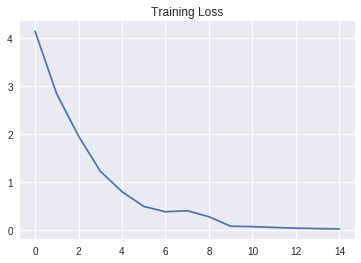

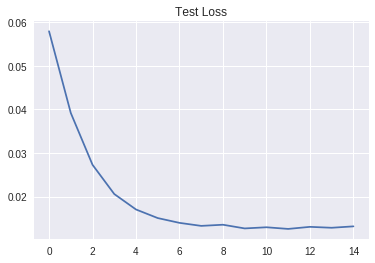

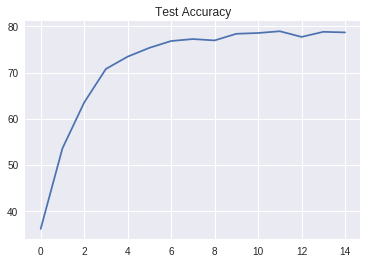

In [13]:
plotGraph(range(epochs), trainLoss, 'Epochs', 'Loss', 'Training Loss')
plotGraph(range(epochs), testLoss, 'Epochs', 'Loss', 'Test Loss')
plotGraph(range(epochs), testAcc, 'Epochs', 'Accuracy', 'Test Accuracy')